In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [9]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 20. # unit: angstrom
xavg = 50.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
W = 10
H = 5
d = H
V_eq = doulbe_well_width_height(xref, W, H, xavg, d)
F_eq = force_doulbe_well_width_height(xref, W, H, xavg)
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq

## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [12]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 100e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 100000 data points.


#### read simulated trajectory from jld file

In [13]:
# Read simulated trajectory from jld file
f_in = "../trajectory/doublewell_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
W = load(f_in, "W")
H = load(f_in, "H")
D = load(f_in, "D");

### Part 4: Do KDE and plot

In [14]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
peq_kde_estimate = gaussian_kde(xref, y_record, sigma_by_keq, w0);

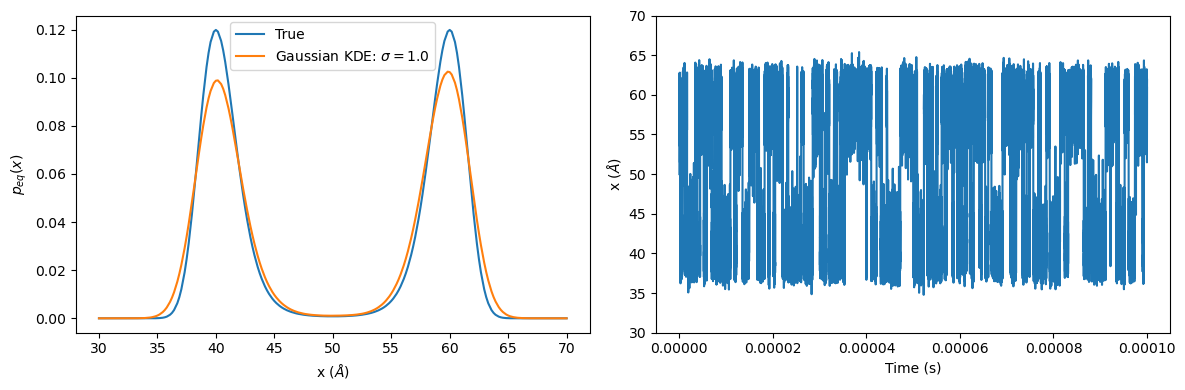

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, peq_kde_estimate, label="Gaussian KDE: \$\\sigma=1.0 \$")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()


ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

### Part: EM

In [16]:
n_iteration = 20
p_container = zeros(Float64, n_iteration+1, N)
log_likelihood_records = zeros(n_iteration+1)
        
# Iteration of EM
p_prev = max.(peq_kde_estimate, 1e-10)  # initial guess
p_container[1, :] = max.(peq_kde_estimate, 1e-10) # The first row in container is p0
for iter_id = 1:n_iteration
    println(@sprintf "Iteration-ID: %d" iter_id)
    p_em, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, p_prev, D, Nv, tau, y_record, save_freq, k_photon)
    p_em = max.(p_em, 1e-10)   
    p_container[iter_id+1, :] = p_em    
    p_prev[:,1] = p_em
    log_likelihood_records[iter_id] = log_likelihood
end

Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Iteration-ID: 4
Iteration-ID: 5
Iteration-ID: 6
Iteration-ID: 7
Iteration-ID: 8
Iteration-ID: 9
Iteration-ID: 10
Iteration-ID: 11
Iteration-ID: 12
Iteration-ID: 13
Iteration-ID: 14
Iteration-ID: 15
Iteration-ID: 16
Iteration-ID: 17
Iteration-ID: 18
Iteration-ID: 19
Iteration-ID: 20


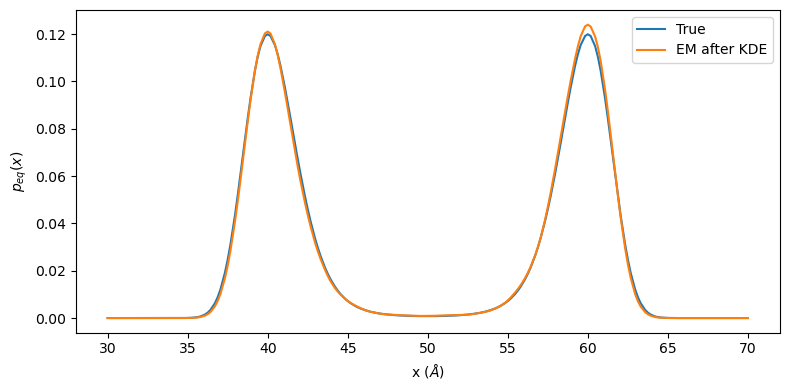

In [18]:
em_id_sele = 20

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, p_container[em_id_sele, :], label="EM after KDE")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

plt.tight_layout()
plt.show()